#### imports

In [ ]:
# If you don't run this cell, arviz will give you an error. 
# This is the only fix I could find. 
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 5.8MB/s 
     |████████████████████████████████| 4.7MB 37.7MB/s 
     |████████████████████████████████| 317kB 51.6MB/s 
     |████████████████████████████████| 911kB 4.4MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 2.8MB 3.1MB/s 
  Created wheel for Theano: filename=Theano-1.0.4-cp37-none-any.whl size=2667178 sha256=13ef1936ac911a03a36691599017acac114a7208b473d4060eb325ff8888f365
  Stored in directory: /root/.cache/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import arviz as az
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
# from theano import shared
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_squared_error

### data pre-processing
remove nulls, define data frame.. etc

In [ ]:
DATASET_PATH = '/content/drive/Shareddrives/CS506_Team/Data/Blake_RPD_Dataset-2.xlsx'
df = pd.read_excel(DATASET_PATH, "data") # data is the sheet name
tft = ['tft' + str(i) for i in range(1,11)]
tft_rt = ['tft_rt' + str(i) for i in range(1,11)]
coop = ['coop' + str(i) for i in range(1,11)]
coop_rt = ['coop_rt' + str(i) for i in range(1,11)]
defs = ['def' + str(i) for i in range(1,11)]
def_rt = ['def_rt' + str(i) for i in range(1,11)]
features = [tft, tft_rt, coop, coop_rt, defs, def_rt]
#Dropping rows with NaN values:
dropped_len = df.shape[0] - df.dropna().shape[0] 
data = df.dropna() #Now, we have a clean data frame.
data

,RPD_code,Age_months,Age_years,Gender,Location,P-SDQ_Conduct,P-SDQ_Emo,P-SDQ_Hyper,P-SDQ_Peer,P-SDQ_Procosial,P-SDQ_Total_Problems,P-Proactive_aggr,P-Reactive_aggr,P-Aggression_Total,Order,tft1,tft_rt1,tft2,tft_rt2,tft3,tft_rt3,tft4,tft_rt4,tft5,tft_rt5,tft6,tft_rt6,tft7,tft_rt7,tft8,tft_rt8,tft9,tft_rt9,tft10,tft_rt10,coop1,coop_rt1,coop2,coop_rt2,coop3,coop_rt3,coop4,coop_rt4,coop5,coop_rt5,coop6,coop_rt6,coop7,coop_rt7,coop8,coop_rt8,coop9,coop_rt9,coop10,coop_rt10,def1,def_rt1,def2,def_rt2,def3,def_rt3,def4,def_rt4,def5,def_rt5,def6,def_rt6,def7,def_rt7,def8,def_rt8,def9,def_rt9,def10,def_rt10
0,1J0NDS,130,10,1,0,2.0,7.0,0.0,1.0,8.0,10,1.0,7.0,8.0,1,1,1.39,1,3.45,0,1.13,1,6.01,0,1.35,0,1.54,1,2.77,0,1.87,0,3.43,1,9.97,1,2.64,1,1.09,1,1.20,0,0.60,0,1.64,0,2.07,1,1.77,1,1.15,0,2.17,1,3.58,1,2.48,0,1.18,1,1.35,0,2.25,0,1.21,0,1.29,1,0.92,0,3.27,0,4.81,0,1.82
1,1J3aGy,142,11,1,0,2.0,6.0,1.0,4.0,9.0,13,1.0,3.0,4.0,1,1,4.94,1,3.68,1,0.82,1,0.31,1,1.37,1,0.36,1,0.99,1,0.81,1,0.62,1,3.68,0,4.81,1,1.73,1,4.79,0,2.80,1,1.39,0,2.39,1,1.19,1,0.93,1,0.62,1,0.36,0,0.22,0,1.61,0,1.30,1,1.74,0,1.22,0,0.45,0,0.85,1,1.00,0,0.60,0,1.08
2,1yfy8K,122,10,1,0,1.0,0.0,1.0,0.0,6.0,2,0.0,1.0,1.0,0,1,3.50,0,5.06,0,3.48,1,2.61,1,1.90,0,2.15,0,2.87,0,7.77,1,4.48,0,1.39,0,1.82,0,1.03,0,0.45,0,0.49,0,0.42,0,0.66,0,0.61,0,1.42,0,0.76,0,1.17,1,3.91,0,1.90,0,2.73,0,1.71,0,0.45,0,0.73,0,0.16,0,1.00,0,0.35,0,0.43
3,2ER9VQ,109,9,1,0,1.0,3.0,0.0,2.0,10.0,6,0.0,4.0,4.0,0,0,8.86,0,5.91,0,6.96,0,2.64,0,2.73,0,4.65,1,11.43,0,2.64,0,2.64,0,0.27,0,1.59,0,2.80,0,5.92,0,3.83,0,3.26,0,1.54,0,0.97,0,1.96,0,1.32,0,0.83,0,1.27,0,0.97,0,0.64,0,3.78,0,2.55,0,0.58,0,4.04,0,1.60,0,1.59,0,11.78
4,2r04de,110,9,0,0,0.0,1.0,0.0,1.0,10.0,2,0.0,1.0,1.0,1,1,0.99,1,2.54,0,1.89,1,1.84,1,0.81,0,3.05,0,1.59,0,5.02,0,0.55,0,4.00,0,3.86,1,1.34,0,1.14,1,0.35,1,0.76,1,0.52,1,1.33,0,0.82,1,1.46,0,1.70,1,1.51,0,0.36,0,0.29,0,0.99,0,0.61,0,0.28,0,0.26,1,0.31,0,0.26,0,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Z4GB1Z,133,11,0,0,1.0,4.0,1.0,4.0,6.0,10,0.0,3.0,3.0,0,0,3.35,0,10.59,1,2.05,1,3.83,0,3.25,1,1.32,1,3.42,1,3.90,0,3.44,1,9.88,1,11.59,1,1.09,1,0.48,1,1.44,0,0.80,0,1.68,1,0.94,0,0.77,0,1.93,1,3.76,1,0.79,0,1.35,0,2.01,0,1.42,1,0.88,0,1.78,0,2.54,0,2.53,1,0.54,0,1.27
163,zARNzA,114,9,0,1,3.0,5.0,4.0,5.0,3.0,17,1.0,6.0,7.0,1,0,6.20,0,0.21,0,0.01,0,0.10,0,0.93,0,0.05,0,0.24,0,0.15,0,0.11,0,0.15,0,0.20,0,0.03,0,0.22,0,0.25,0,0.02,0,0.07,0,0.12,0,0.11,0,0.24,0,0.27,0,0.05,0,0.04,0,0.01,0,0.11,0,0.09,0,0.08,0,0.05,0,0.38,0,0.37,0,0.18
164,zHDAMO,134,11,1,0,0.0,2.0,0.0,1.0,10.0,3,0.0,0.0,0.0,0,0,3.67,0,3.73,0,1.69,0,1.17,0,1.99,0,0.17,0,2.14,0,0.82,0,0.86,0,9.78,0,6.58,0,1.05,0,1.16,0,0.92,0,0.73,0,0.75,0,0.89,0,0.49,0,1.49,0,0.88,0,0.12,0,1.48,0,0.71,0,0.55,0,0.58,0,0.34,0,0.87,0,2.06,0,0.37,0,0.57
165,ZLEEv9,133,11,1,0,2.0,0.0,4.0,1.0,9.0,7,0.0,3.0,3.0,1,1,2.09,0,6.23,1,0.96,1,5.50,0,9.47,1,3.29,0,1.50,1,4.76,0,4.18,1,4.10,1,1.76,1,4.12,1,1.33,0,1.04,1,1.57,1,0.78,1,0.74,0,1.26,1,1.11,1,1.64,1,1.34,0,0.72,0,2.44,1,0.62,0,2.52,0,0.93,1,3.46,1,3.73,0,1.28,0,0.42


# Using Bayesian models:
In this notebook, I use bayesian models for two purposes: 


*   Predicting a child's aggression score based on their gaming strategy
*   Predicting the child's next move based on aggression score and stratgey on previous rounds 

So far, I was only able to make progress with the first goal.



## Implementing a Naive Bayesian classifier for multivariate Bernoulli models

I chose this classifier because it is suitable for discrete data.It works similarity as a multinomial bayesian classifier, however this is designed for binary/boolean features - much like our defect/cooperate features. 


first, let us prep the data. I want to create a dataframe using tft and proactive aggression. 

### proactive aggression & tft 

Now, let us get to know our data a little more. I want to know more about our proactive aggression scores.

In [ ]:
# data frame that includes proactive agression scores and tft rounds 
proactive_tft = ["P-Proactive_aggr"]
proactive_tft.extend(tft)
proactive_tft_data = data[proactive_tft]
data['P-Proactive_aggr'].describe()


count    144.000000
mean       0.902778
std        1.236504
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        6.000000
Name: P-Proactive_aggr, dtype: float64

In [ ]:
data['P-Proactive_aggr'].value_counts()


0.0    72
1.0    42
2.0    14
3.0     8
4.0     5
5.0     2
6.0     1
Name: P-Proactive_aggr, dtype: int64

Now, let us prep our data for our classifier. 

In [ ]:
X = proactive_tft_data.drop(columns=['P-Proactive_aggr'])
y = proactive_tft_data['P-Proactive_aggr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


In [ ]:
print(proactive_tft_data)

     P-Proactive_aggr  tft1  tft2  tft3  tft4  ...  tft6  tft7  tft8  tft9  tft10
0                 1.0     1     1     0     1  ...     0     1     0     0      1
1                 1.0     1     1     1     1  ...     1     1     1     1      1
2                 0.0     1     0     0     1  ...     0     0     0     1      0
3                 0.0     0     0     0     0  ...     0     1     0     0      0
4                 0.0     1     1     0     1  ...     0     0     0     0      0
..                ...   ...   ...   ...   ...  ...   ...   ...   ...   ...    ...
162               0.0     0     0     1     1  ...     1     1     1     0      1
163               1.0     0     0     0     0  ...     0     0     0     0      0
164               0.0     0     0     0     0  ...     0     0     0     0      0
165               0.0     1     0     1     1  ...     1     0     1     0      1
166               1.0     1     0     0     1  ...     0     0     0     0      0

[144 rows x 11 

  Predicting proactive aggression score using TFT

```
# This is formatted as code
```



Number of mislabeled points out of a total 36 points : 16
accuracy: 0.5555555555555556
RMSE:  2.4722222222222223


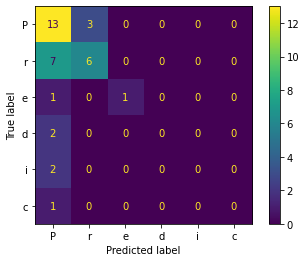

In [ ]:
clf = BernoulliNB()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print("accuracy:", accuracy_score(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test, display_labels="Predicting proactive aggression score using TFT")

Preditcing Proactive using *coop*

In [ ]:
X2 = data[coop]
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.25, random_state=0)


Number of mislabeled points out of a total 36 points : 20
accuracy: 0.4444444444444444
RMSE:  2.4722222222222223


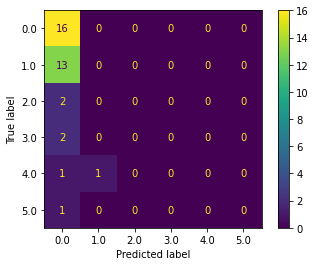

In [ ]:
clf2 = MultinomialNB()
y_pred = clf2.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print("accuracy:", accuracy_score(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred))
plot_confusion_matrix(clf2, X_test, y_test)

proactive using **def**

Number of mislabeled points out of a total 36 points : 20
accuracy: 0.4444444444444444
RMSE:  2.6666666666666665


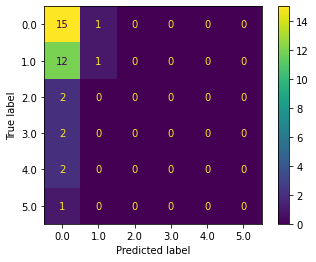

In [ ]:
X3 = data[defs]
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.25, random_state=0)
clf3 = MultinomialNB()
y_pred = clf3.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print("accuracy:", accuracy_score(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred))
plot_confusion_matrix(clf3, X_test, y_test)

### Reactive aggression & defective rounds: This doesn't seem to work at all.. I wonder why? It gave an accuracy of 0.18 


In [ ]:
# data frame that includes reactive agression scores and defensive rounds 
reactive_defs = ["P-Reactive_aggr"]
reactive_defs.extend(defs)
reactive_defs_data = data[reactive_defs]
data['P-Reactive_aggr'].describe()

count    144.000000
mean       2.854167
std        2.356270
min        0.000000
25%        1.000000
50%        2.000000
75%        4.250000
max       10.000000
Name: P-Reactive_aggr, dtype: float64

In [ ]:
X = reactive_defs_data.drop(columns=['P-Reactive_aggr'])
y = reactive_defs_data['P-Reactive_aggr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

Number of mislabeled points out of a total 22 points : 18
accuracy: 0.18181818181818182
RMSE:  10.818181818181818


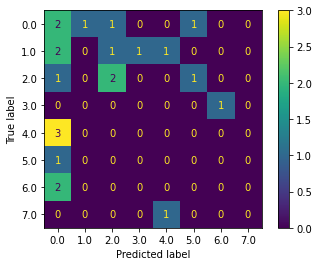

In [ ]:
clf = BernoulliNB()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print("accuracy:", accuracy_score(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test)

reactive and tft

Number of mislabeled points out of a total 22 points : 16
accuracy: 0.2727272727272727
RMSE:  11.045454545454545


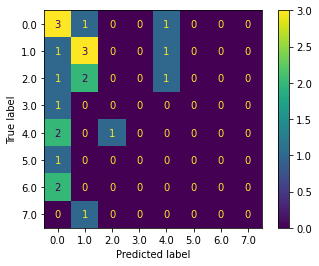

In [ ]:
X4 = data[tft]
y = reactive_defs_data['P-Reactive_aggr']
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.15, random_state=0)
clf = BernoulliNB()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print("accuracy:", accuracy_score(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test)

reactive and coop

Number of mislabeled points out of a total 22 points : 15
accuracy: 0.3181818181818182
RMSE:  11.318181818181818


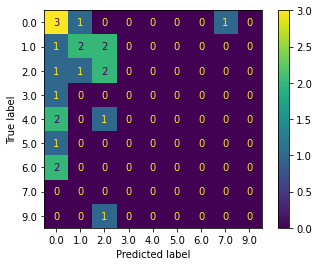

In [ ]:
X5 = data[coop]
y = reactive_defs_data['P-Reactive_aggr']
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.15, random_state=0)
clf = BernoulliNB()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print("accuracy:", accuracy_score(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test)

## Implementing a Bayesian Statistical model using PYMC3

This model seems to work, but I am not sure what the below plots signify. I need help using this model to predict future responses.  

In [ ]:

with pm.Model() as model:
    p = pm.Beta( 'p', alpha=2, beta=2 )
    y = pm.Binomial('y_tft', 10, p, observed= proactive_tft_data)
    step = pm.Metropolis()
    trace = pm.sample( 10000, step=step, progressbar=True )


Sequential sampling (2 chains in 1 job)
Metropolis: [p]
Sampling chain 1, 0 divergences: 100%|██████████| 10500/10500 [00:02<00:00, 4647.15it/s]
The number of effective samples is smaller than 10% for some parameters.


Here we see the marginalized distribution for each parameter on the left and the trace plot (parameter value as a function of step number) on the right.

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


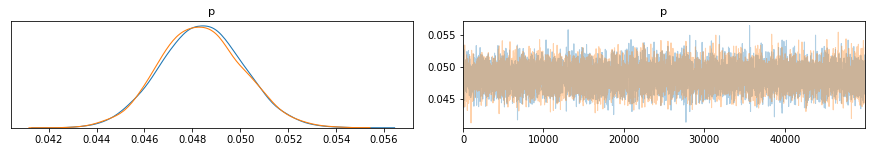

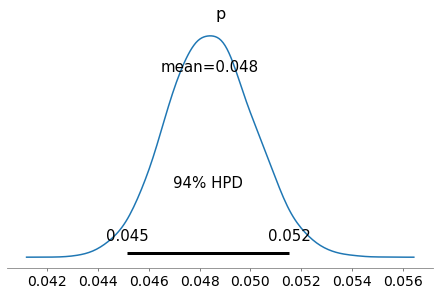

In [ ]:
pm.traceplot(trace )
pm.plot_posterior(trace)
plt.show()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.048,0.002,0.045,0.052,0.0,0.0,1902.0,1902.0,1907.0,1855.0,1.0
